# 1. Imports

In [2]:
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np

# 2. Data 

## 2.1 Loaders

### 2.1.1 MNIST Data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
    ])
batch_size = 64

datasets_save_dir = 'Data/'

train_data = datasets.MNIST(root=datasets_save_dir,download=True,train=True, 
    transform=transform)
test_data = datasets.MNIST(root=datasets_save_dir,download=True,train=False, 
    transform=transform)

all_train_size = len(train_data)
little_train_size = int(0.8 * all_train_size)
val_size = all_train_size - little_train_size

little_train_dataset, val_dataset = random_split(train_data, [little_train_size, val_size])

little_train_dataloader = DataLoader(little_train_dataset,batch_size=batch_size,
    shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)
train_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=True)

### 2.1.2 Subsets

In [4]:
subset_sizes = [1000*i for i in range(1,6)] 

subset_loaders = []
for subset_size in subset_sizes:
    subset, _ = random_split(little_train_dataset, [subset_size, little_train_size  - subset_size])
    subset_loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    subset_loaders.append(subset_loader)

## 2.2 Data shape

In [5]:
for images, labels in little_train_dataloader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


# 3. Models

## 3.1 Standard Fcnn

In [6]:
class Fcnn(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x
    

    def weights_normal(self,mean,std):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=mean, std=std) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def weights_ones(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.ones_(m.weight) 
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

## 3.2 Fcnn + dropout

In [7]:
class Fcnn_dropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Linear(28*28,256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256,64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64,10),
            nn.Softmax()
        )

    def forward(self,x):
        x = self.block_1(x)
        return x

# 4. Utility functions

In [8]:
def train(epochs:int,model,optimizer,criterion,data):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        batch_loss = []
        for batch, (images,labels) in enumerate(data):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels) 
            loss.backward()

            optimizer.step()
            
            batch_loss.append(loss.item())
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(data)}, loss: {loss.item():.4f}')
        avg_batch_loss = sum(batch_loss)/len(batch_loss)
        loss_history.append(avg_batch_loss)
            
    print('Finished training!')
    return loss_history

In [9]:
def test(model, dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            output = model(images)
            pred = output.data.max(1,keepdim=True)[1]
            
            labels = labels.data.view_as(pred)
            correct += pred.eq(labels).sum()
    accuracy = correct/len(dataloader.dataset)
    print(f'Accuracy: {accuracy:.3f}')
    return accuracy


In [10]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
         
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
def train_es(epochs:int,model,optimizer,criterion,dataloader):
    early_stopper = EarlyStopper(patience=3)
    loss_history = []
    model.train()
    for epoch in range(epochs):
        batch_loss_history = []
        for batch, (images,labels) in enumerate(dataloader):
            images = images.view(images.shape[0],-1)

            optimizer.zero_grad()
            
            output = model(images)

            loss = criterion(output,labels)
            loss.backward()

            optimizer.step()
            if (batch+1) % 100 == 0:
                print(f'epoch: {epoch+1}, step: {batch+1}/{len(dataloader)} , loss: {loss.item():.4f}')
            batch_loss_history.append(loss.item())
        
        epoch_avg_loss = np.average(batch_loss_history)
        loss_history.append(epoch_avg_loss)

        print(f'Epoch: {epoch+1}, avg_loss = {epoch_avg_loss}')
        if early_stopper.early_stop(epoch_avg_loss):
            print('Early stopping!')
            break
    print('Finished training!')
    return loss_history



# 5. Weight initialization

W tej sekcji będziemy zajmować się analizą różnych podejść do inicjalizacji wag. Omawiane będą następujące modele:
1. Model z wagami bliskimi 0 (bez manualnej inicjalizacji)
2. Model z dużymi wagami, gdzie $\mu=1000$ oraz $\sigma = 20$
3. Model z wagami równymi 1

## 5.1 Settings

In [11]:
epochs = 8
criterion = nn.CrossEntropyLoss()

## 5.2 Training

### 5.2.1 No manual weight initialization (weights near 0)

In [12]:
model_1 = Fcnn()
optimizer = torch.optim.Adam(model_1.parameters())

loss_history_1 = train(epochs, model_1, optimizer, criterion, little_train_dataloader)

c:\Users\Komputer\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


epoch: 1, step: 100/750, loss: 1.7198
epoch: 1, step: 200/750, loss: 1.7446
epoch: 1, step: 300/750, loss: 1.6932
epoch: 1, step: 400/750, loss: 1.5899
epoch: 1, step: 500/750, loss: 1.5324
epoch: 1, step: 600/750, loss: 1.6173
epoch: 1, step: 700/750, loss: 1.5702
epoch: 2, step: 100/750, loss: 1.5289
epoch: 2, step: 200/750, loss: 1.5244
epoch: 2, step: 300/750, loss: 1.5455
epoch: 2, step: 400/750, loss: 1.5140
epoch: 2, step: 500/750, loss: 1.5798
epoch: 2, step: 600/750, loss: 1.6347
epoch: 2, step: 700/750, loss: 1.5837
epoch: 3, step: 100/750, loss: 1.5364
epoch: 3, step: 200/750, loss: 1.5184
epoch: 3, step: 300/750, loss: 1.5590
epoch: 3, step: 400/750, loss: 1.4944
epoch: 3, step: 500/750, loss: 1.5277
epoch: 3, step: 600/750, loss: 1.5088
epoch: 3, step: 700/750, loss: 1.4915
epoch: 4, step: 100/750, loss: 1.5157
epoch: 4, step: 200/750, loss: 1.5173
epoch: 4, step: 300/750, loss: 1.5373
epoch: 4, step: 400/750, loss: 1.5128
epoch: 4, step: 500/750, loss: 1.4875
epoch: 4, st

### 5.2.2 Large weights

In [13]:
model_2 = Fcnn()
optimizer = torch.optim.Adam(model_2.parameters())
model_2.weights_normal(mean=1000, std=20)

loss_history_2 = train(epochs, model_2, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3029
epoch: 1, step: 200/750, loss: 2.3026
epoch: 1, step: 300/750, loss: 2.3027
epoch: 1, step: 400/750, loss: 2.3028
epoch: 1, step: 500/750, loss: 2.3026
epoch: 1, step: 600/750, loss: 2.3033
epoch: 1, step: 700/750, loss: 2.3033
epoch: 2, step: 100/750, loss: 2.3020
epoch: 2, step: 200/750, loss: 2.3008
epoch: 2, step: 300/750, loss: 2.3020
epoch: 2, step: 400/750, loss: 2.3030
epoch: 2, step: 500/750, loss: 2.3040
epoch: 2, step: 600/750, loss: 2.2993
epoch: 2, step: 700/750, loss: 2.3022
epoch: 3, step: 100/750, loss: 2.3035
epoch: 3, step: 200/750, loss: 2.3024
epoch: 3, step: 300/750, loss: 2.3023
epoch: 3, step: 400/750, loss: 2.3000
epoch: 3, step: 500/750, loss: 2.3012
epoch: 3, step: 600/750, loss: 2.3017
epoch: 3, step: 700/750, loss: 2.2965
epoch: 4, step: 100/750, loss: 2.3008
epoch: 4, step: 200/750, loss: 2.3034
epoch: 4, step: 300/750, loss: 2.2998
epoch: 4, step: 400/750, loss: 2.2978
epoch: 4, step: 500/750, loss: 2.3030
epoch: 4, st

### 5.2.3 All weights set to 1

In [14]:
model_3 = Fcnn()
optimizer = torch.optim.Adam(model_3.parameters())
model_3.weights_ones()

loss_history_3 = train(epochs, model_3, optimizer, criterion, little_train_dataloader)

epoch: 1, step: 100/750, loss: 2.3020
epoch: 1, step: 200/750, loss: 2.3025
epoch: 1, step: 300/750, loss: 2.3028
epoch: 1, step: 400/750, loss: 2.3018
epoch: 1, step: 500/750, loss: 2.3022
epoch: 1, step: 600/750, loss: 2.3027
epoch: 1, step: 700/750, loss: 2.3024
epoch: 2, step: 100/750, loss: 2.3005
epoch: 2, step: 200/750, loss: 2.3007
epoch: 2, step: 300/750, loss: 2.3034
epoch: 2, step: 400/750, loss: 2.3004
epoch: 2, step: 500/750, loss: 2.3036
epoch: 2, step: 600/750, loss: 2.2973
epoch: 2, step: 700/750, loss: 2.3025
epoch: 3, step: 100/750, loss: 2.2993
epoch: 3, step: 200/750, loss: 2.3033
epoch: 3, step: 300/750, loss: 2.3019
epoch: 3, step: 400/750, loss: 2.2973
epoch: 3, step: 500/750, loss: 2.2999
epoch: 3, step: 600/750, loss: 2.3088
epoch: 3, step: 700/750, loss: 2.3045
epoch: 4, step: 100/750, loss: 2.2994
epoch: 4, step: 200/750, loss: 2.2972
epoch: 4, step: 300/750, loss: 2.3009
epoch: 4, step: 400/750, loss: 2.3044
epoch: 4, step: 500/750, loss: 2.2928
epoch: 4, st

## 5.3 Results

### 5.3.1 Testing

In [15]:
accuracy_1 = test(model_1, test_dataloader)
accuracy_2 = test(model_2, test_dataloader)
accuracy_3 = test(model_3, test_dataloader)
print(f'Model 1 accuracy: {accuracy_1:.2f}, Model 2 accuracy: {accuracy_2:.2f}, Model 3 accuracy: {accuracy_3:.2f}')

Accuracy: 0.961
Accuracy: 0.113
Accuracy: 0.113
Model 1 accuracy: 0.96, Model 2 accuracy: 0.11, Model 3 accuracy: 0.11


### 5.3.2 Visualization

#### 5.3.2.1 Loss function 

C:\Users\Komputer\AppData\Local\Temp\ipykernel_20880\306140487.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 3, 1)


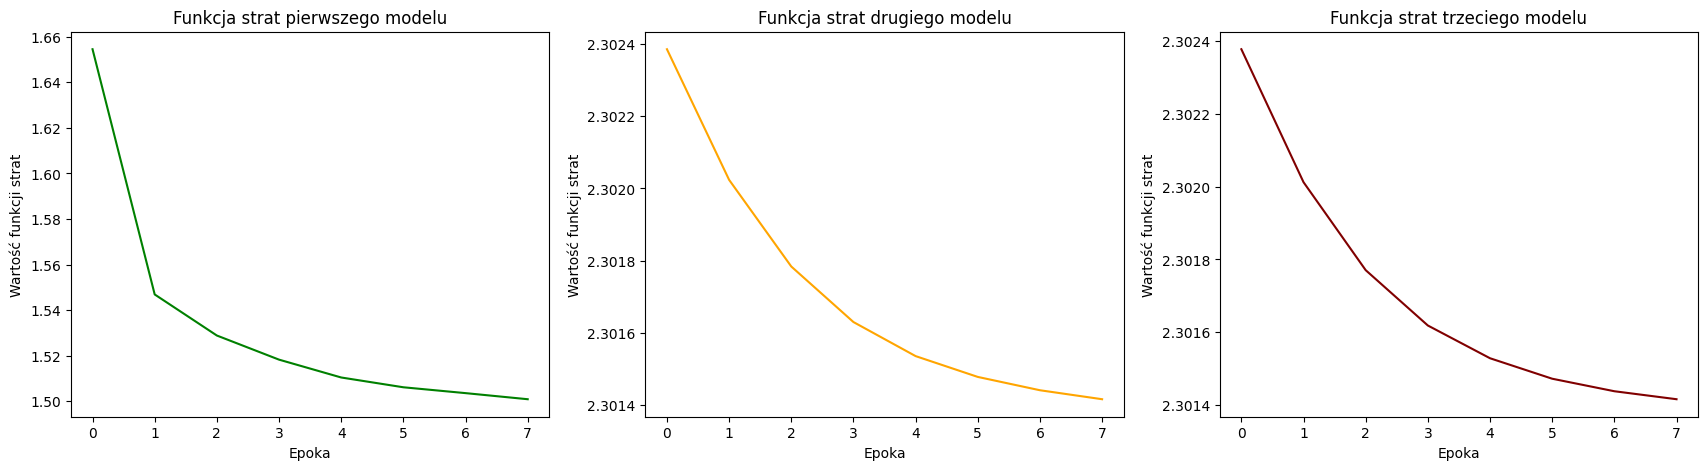

In [16]:
plt.subplots(figsize=(21, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_history_1, color='green')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat pierwszego modelu')

plt.subplot(1, 3, 2)
plt.plot(loss_history_2, color='orange')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat drugiego modelu')

plt.subplot(1, 3, 3)
plt.plot(loss_history_3, color='maroon')
plt.xlabel('Epoka')
plt.ylabel('Wartość funkcji strat')
plt.title('Funkcja strat trzeciego modelu')

plt.show()

#### 5.3.2.2 Accuracy barplots

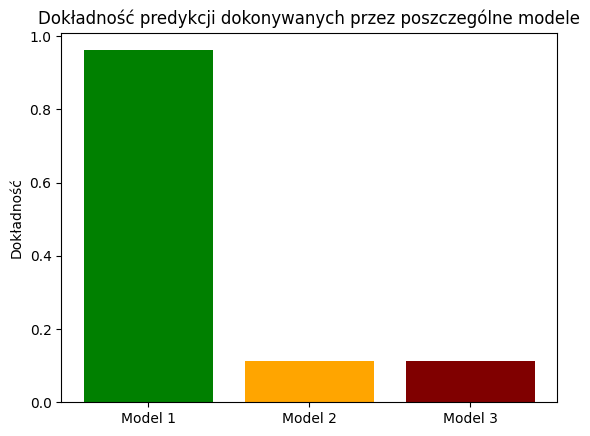

In [17]:
plt.bar(['Model 1', 'Model 2', 'Model 3'], [accuracy_1, accuracy_2, accuracy_3], color=['green', 'orange', 'maroon'])
plt.title('Dokładność predykcji dokonywanych przez poszczególne modele')
plt.ylabel('Dokładność')

plt.show()

Domyślne wagi zaimplementowane przez PyTorch (użyte w pierwszym modelu), czyli bardzo bliskie 0, działają najlepiej. Wyniki uzyskiwane przez model można wówczas uznać za satysfakcjonujące. Inicjalizacja innych wag sprawia, że wyniki predykcji modelu są bardzo dalekie od oczekiwań. Dotyczy to zarówno poprawności predykcji jak i funkcji strat.

# 6. Training on subsets of different sizes

W tym rozdziale zajmiemy się analizą uczenia sieci neuronowej w zależności od wielkości zbioru treningowego.
Następnie porównamy dokładność tych sieci na zbiorze walidacyjnym oraz testowym. 

## 6.1 Training loop

In [18]:
subset_loss_history = []
subset_accuracy_train = []
subset_accuracy_test = []

for subset in subset_loaders:
    subset_model = Fcnn()
    optimizer = torch.optim.Adam(subset_model.parameters())
    loss_history = train(3,subset_model,optimizer,criterion,subset)
    subset_loss_history.append(loss_history)

    accuracy_test = test(subset_model,test_dataloader)
    accuracy_train = test(subset_model,val_dataloader)
    
    subset_accuracy_train.append(accuracy_train)
    subset_accuracy_test.append(accuracy_test)

Finished training!
Accuracy: 0.646
Accuracy: 0.651
Finished training!
Accuracy: 0.682
Accuracy: 0.681
Finished training!
Accuracy: 0.814
Accuracy: 0.803
Finished training!
Accuracy: 0.771
Accuracy: 0.760
Finished training!
Accuracy: 0.803
Accuracy: 0.800


## 6.2 Results visualized

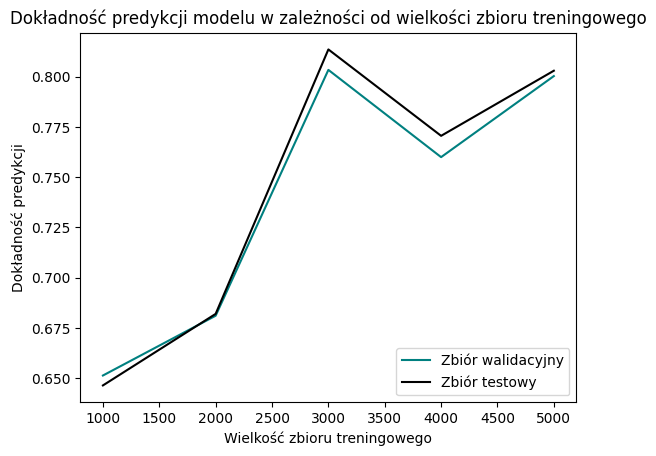

In [25]:
plt.plot(subset_sizes, subset_accuracy_train, label='Zbiór walidacyjny', color='teal')
plt.plot(subset_sizes, subset_accuracy_test, label='Zbiór testowy', color='black')

plt.xlabel('Wielkość zbioru treningowego')
plt.ylabel('Dokładność predykcji')
plt.title('Dokładność predykcji modelu w zależności od wielkości zbioru treningowego')

plt.legend(loc='lower right')

Na powyższym wykresie możemy zauważyć trend wzrostowy w zależności pomiędzy zwiększaniem zbioru treningowego a dokładnością predykcji modelu.

# 7. Early stopping

W tym rozdziale zajmiemy się pokazaniem, w jaki sposób działa uczenie sieci neuronowej z zastosowaniem early-stoppingu. Ze względu na dużą ilość danych, by łatwiej było aktywować proces overfittingu, a tym samym aktywowania early-stoppingu, szybkość uczenia jest bardzo wysoka i wynosi 1. 

## 7.1 Training

In [20]:
epochs = 35

model_4 = Fcnn()
learning_rate = 1
optimizer = torch.optim.SGD(model_4.parameters(),lr=learning_rate)

loss_history_4 = train_es(epochs, model_4, optimizer, criterion, dataloader=train_dataloader)

epoch: 1, step: 100/157 , loss: 1.9576
Epoch: 1, avg_loss = 2.0393892162165064
epoch: 2, step: 100/157 , loss: 1.7891
Epoch: 2, avg_loss = 1.740388639413627
epoch: 3, step: 100/157 , loss: 1.6179
Epoch: 3, avg_loss = 1.6723131214737132
epoch: 4, step: 100/157 , loss: 1.7066
Epoch: 4, avg_loss = 1.6568122145476614
epoch: 5, step: 100/157 , loss: 1.6887
Epoch: 5, avg_loss = 1.6587100188443615
epoch: 6, step: 100/157 , loss: 1.5353
Epoch: 6, avg_loss = 1.6575638837875075
epoch: 7, step: 100/157 , loss: 1.5852
Epoch: 7, avg_loss = 1.5999463356224595
epoch: 8, step: 100/157 , loss: 1.6307
Epoch: 8, avg_loss = 1.6342664045892703
epoch: 9, step: 100/157 , loss: 1.6037
Epoch: 9, avg_loss = 1.6040670894513465
epoch: 10, step: 100/157 , loss: 1.5549
Epoch: 10, avg_loss = 1.5782288031972898
epoch: 11, step: 100/157 , loss: 1.5582
Epoch: 11, avg_loss = 1.5798372311197268
epoch: 12, step: 100/157 , loss: 1.5289
Epoch: 12, avg_loss = 1.5828620043529826
epoch: 13, step: 100/157 , loss: 1.5562
Epoch: 

## 7.2 Test

In [21]:
accuracy_4 = test(model_4, test_dataloader)

Accuracy: 0.898


## 7.3 Visualization

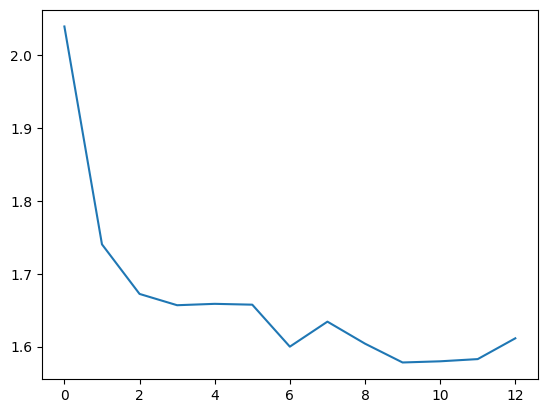

In [22]:
plt.plot(loss_history_4)

Na wykresie powyżej widać wyraźnie od pewnego momentu wzrost funkcji strat. Po ustalonych trzech epokach takiego wzrostu zadziałał early-stopping i zakończył trening.

# 8. Dropout

In [23]:
model_5 = Fcnn_dropout()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_5.parameters())

epochs = 8
train_es(epochs, model_5, optimizer, criterion, dataloader=train_dataloader)

epoch: 1, step: 100/157 , loss: 1.7236
Epoch: 1, avg_loss = 1.8701565622524092
epoch: 2, step: 100/157 , loss: 1.6193
Epoch: 2, avg_loss = 1.641893458214535
epoch: 3, step: 100/157 , loss: 1.6146
Epoch: 3, avg_loss = 1.5869909281943255
epoch: 4, step: 100/157 , loss: 1.5688
Epoch: 4, avg_loss = 1.570735421909648
epoch: 5, step: 100/157 , loss: 1.6107
Epoch: 5, avg_loss = 1.564245390284593
epoch: 6, step: 100/157 , loss: 1.5597
Epoch: 6, avg_loss = 1.5576972232502737
epoch: 7, step: 100/157 , loss: 1.5290
Epoch: 7, avg_loss = 1.545904620437865
epoch: 8, step: 100/157 , loss: 1.4705
Epoch: 8, avg_loss = 1.540091160756008
Finished training!


[1.8701565622524092,
 1.641893458214535,
 1.5869909281943255,
 1.570735421909648,
 1.564245390284593,
 1.5576972232502737,
 1.545904620437865,
 1.540091160756008]

In [24]:
accuracy_5 = test(model_5, test_dataloader)

Accuracy: 0.939
